In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
import warnings 
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Define data transformations for training, validation, and test sets
train_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

BATCH_SIZE = 32
train_data = torchvision.datasets.ImageFolder(root='/kaggle/input/ferrr2023/FER2013/train', transform=train_transforms)

test_data = torchvision.datasets.ImageFolder(root='/kaggle/input/ferrr2023/FER2013/test', transform=test_transforms)

# Define data loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
num_classes_train = len(train_data.classes)
num_classes_test = len(test_data.classes)

print("Number of classes in training set:", num_classes_train)
print("Number of classes in test set:", num_classes_test)


Number of classes in training set: 6
Number of classes in test set: 6


In [5]:
# Get the shape of images in train and test sets
train_images_shape = next(iter(train_loader))[0].shape
test_images_shape = next(iter(test_loader))[0].shape

print("shape (training set):", train_images_shape)
print("shape (test set):", test_images_shape)

# Count of images
train_count = len(train_data)
test_count = len(test_data)

print("training set:", train_count)
print("test set:", test_count)


shape (training set): torch.Size([32, 3, 224, 224])
shape (test set): torch.Size([32, 3, 224, 224])
training set: 28227
test set: 7060


In [6]:
emotion_categories = ['Anger', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']
category_count = len(emotion_categories)
class_index_map = {idx: emotion_categories[idx] for idx in range(category_count)}

In [7]:
import torch.nn as nn
from math import ceil

class ConvBatchNormActivation(nn.Module):
    def __init__(self, channels_in, channels_out, k_size=3, stride_len=1, 
                 pad=0, groupings=1, use_bn=True, use_activation=True, 
                 use_bias=False):
        super(ConvBatchNormActivation, self).__init__()
        
        self.convolution = nn.Conv2d(channels_in, channels_out, kernel_size=k_size,
                                     stride=stride_len, padding=pad, groups=groupings, bias=use_bias)
        self.batchnorm = nn.BatchNorm2d(channels_out) if use_bn else nn.Identity()
        self.activation = nn.SiLU() if use_activation else nn.Identity()
        
    def forward(self, input_tensor):
        input_tensor = self.convolution(input_tensor)
        input_tensor = self.batchnorm(input_tensor)
        input_tensor = self.activation(input_tensor)
        return input_tensor
    

class SEBlock(nn.Module):
    def __init__(self, channels_input, reduced_ch):
        super(SEBlock, self).__init__()
        
        self.squeeze_excite = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels_input, reduced_ch, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(reduced_ch, channels_input, kernel_size=1),
            nn.Sigmoid()
        )
       
    def forward(self, input_tensor):
        output_tensor = self.squeeze_excite(input_tensor)
        return input_tensor * output_tensor
                                    

class StochasticDepthLayer(nn.Module):
    def __init__(self, survival_chance=0.8):
        super(StochasticDepthLayer, self).__init__()
        self.survival_prob = survival_chance
        
    def forward(self, input_tensor):
        if not self.training:
            return input_tensor
        
        random_tensor = torch.rand(input_tensor.shape[0], 1, 1, 1, device=input_tensor.device) < self.survival_prob
        return torch.div(input_tensor, self.survival_prob) * random_tensor


class MBConvBlock(nn.Module):
    def __init__(self, channels_in, channels_out, k_size=3, stride_len=1, 
                 expansion_factor=6, reduction_ratio=4, survival_chance=0.8):
        super(MBConvBlock, self).__init__()
        
        self.use_skip = (stride_len == 1 and channels_in == channels_out)
        intermediate_ch = int(channels_in * expansion_factor)
        pad = (k_size - 1) // 2
        reduced_ch = int(channels_in // reduction_ratio)
        
        self.expansion = nn.Identity() if (expansion_factor == 1) else ConvBatchNormActivation(channels_in, intermediate_ch, k_size=1)
        self.depthwise_convolution = ConvBatchNormActivation(intermediate_ch, intermediate_ch,
                                                             k_size=k_size, stride_len=stride_len, 
                                                             pad=pad, groupings=intermediate_ch)
        self.squeeze_excitation = SEBlock(intermediate_ch, reduced_ch=reduced_ch)
        self.pointwise_convolution = ConvBatchNormActivation(intermediate_ch, channels_out, 
                                                             k_size=1, use_activation=False)
        self.stochastic_depth = StochasticDepthLayer(survival_chance=survival_chance)
        
    def forward(self, input_tensor):
        residual = input_tensor
        
        input_tensor = self.expansion(input_tensor)
        input_tensor = self.depthwise_convolution(input_tensor)
        input_tensor = self.squeeze_excitation(input_tensor)
        input_tensor = self.pointwise_convolution(input_tensor)
        
        if self.use_skip:
            input_tensor = self.stochastic_depth(input_tensor)
            input_tensor += residual
        
        return input_tensor
    

class CustomEfficientNet(nn.Module):
    def __init__(self, width_multiplier=1, depth_multiplier=1, dropout_prob=0.2, 
                 class_count=category_count, computation_device='cuda'):
        super(CustomEfficientNet, self).__init__()
        self.computation_device = computation_device
        
        final_channel_count = ceil(1280 * width_multiplier)
        self.feature_layers = self._build_feature_layers(width_multiplier, depth_multiplier, final_channel_count)
        self.avg_pool_layer = nn.AdaptiveAvgPool2d(1)
        self.classifier_layer = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(final_channel_count, class_count)
        )
        
    def forward(self, input_tensor):
        input_tensor = input_tensor.to(self.computation_device)
        
        input_tensor = self.feature_layers(input_tensor)
        input_tensor = self.avg_pool_layer(input_tensor)
        input_tensor = self.classifier_layer(input_tensor.view(input_tensor.shape[0], -1))
        
        return input_tensor
    
    def _build_feature_layers(self, width_multiplier, depth_multiplier, final_channel):
        base_channels = 4 * ceil(int(32 * width_multiplier) / 4)
        channels_input = 3
        feature_layers = [ConvBatchNormActivation(channels_input, base_channels, k_size=3, stride_len=2, pad=1)]
        channels_in = base_channels
        
        kernel_sizes = [3, 3, 5, 3, 5, 5, 3]
        expansion_factors = [1, 6, 6, 6, 6, 6, 6]
        channel_counts = [16, 24, 40, 80, 112, 192, 320]
        layer_counts = [1, 2, 2, 3, 3, 4, 1]
        stride_vals =[1, 2, 2, 2, 1, 2, 1]
    
        scaled_channel_counts = [4 * ceil(int(c * width_multiplier) / 4) for c in channel_counts]
        scaled_layer_counts = [int(d * depth_multiplier) for d in layer_counts]

        for i, channel_out in enumerate(scaled_channel_counts):
            feature_layers += [MBConvBlock(channels_in if repeat == 0 else channel_out, 
                                           channel_out, k_size=kernel_sizes[i],
                                           stride_len=stride_vals[i] if repeat == 0 else 1, 
                                           expansion_factor=expansion_factors[i])
                               for repeat in range(scaled_layer_counts[i])]
            channels_in = channel_out
        
        feature_layers.append(ConvBatchNormActivation(channels_in, final_channel, k_size=1, stride_len=1, pad=0))
        return nn.Sequential(*feature_layers)


In [8]:
# Compound scaling factors for efficient-net family.
efficient_net_config = {
    # tuple of width multiplier, depth multiplier, resolution, and Survival Prob
    "b0" : (1.0, 1.0, 224, 0.2),
    "b1" : (1.0, 1.1, 240, 0.2),
    "b2" : (1.1, 1.2, 260, 0.3),
    "b3" : (1.2, 1.4, 300, 0.3),
    "b4" : (1.4, 1.8, 380, 0.4),
    "b5" : (1.6, 2.2, 456, 0.4),
    "b6" : (1.8, 2.6, 528, 0.5),
    "b7" : (2.0, 3.1, 600, 0.5)}

In [9]:
def test():
    computation_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Define the device

    version = 'b0'
    width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
    
    # Create the network and move it to the correct device
    net = CustomEfficientNet(width_mult, depth_mult, dropout_rate, computation_device=computation_device).to(computation_device)

    # Create a test input tensor and move it to the correct device
    x = torch.rand(1, 3, res, res).to(computation_device)

    # Forward pass
    y = net(x)
    print(y.size())

test()

torch.Size([1, 6])


In [10]:
! pip install torchsummary

In [11]:
from torchsummary import summary
computation_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

version = 'b0'
width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]

model = CustomEfficientNet(width_mult, depth_mult, dropout_rate, computation_device=computation_device).to(computation_device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
ConvBatchNormActivation-4         [-1, 32, 112, 112]               0
          Identity-5         [-1, 32, 112, 112]               0
            Conv2d-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
              SiLU-8         [-1, 32, 112, 112]               0
ConvBatchNormActivation-9         [-1, 32, 112, 112]               0
AdaptiveAvgPool2d-10             [-1, 32, 1, 1]               0
           Conv2d-11              [-1, 8, 1, 1]             264
             SiLU-12              [-1, 8, 1, 1]               0
           Conv2d-13             [-1, 32, 1, 1]             288
          Sigmoid-14         

In [12]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [13]:
def run_training(early_stopping_criteria): 

    for current_epoch in range(1, NUM_EPOCHS + 1):

        # Set model to training mode
        model.train()
        batch_train_losses = []
        batch_train_accuracy = []
#         batch_train_f1_scores = []

        for batch_index, data in enumerate(train_loader):
            # Extract images and labels from the current batch
            images, labels = data
            images = images.to(DEVICE)
            labels = labels.long().to(DEVICE)

            # Perform training step
            optimizer.zero_grad()
            predictions = model(images)
            train_loss = criterion(predictions, labels)
            train_loss.backward()
            optimizer.step()

            # Calculate metrics for the batch
            predicted_labels = torch.argmax(predictions, axis=1)
#             f1_score_value = f1_score(predicted_labels.cpu(), labels.cpu(), average='macro')
            accuracy = (predicted_labels == labels).float().mean()
            batch_train_losses.append(train_loss.item())
            batch_train_accuracy.append(accuracy.item())
#             batch_train_f1_scores.append(f1_score_value)

        # Update epoch-level metrics
        avg_train_loss = np.mean(batch_train_losses)
        avg_train_accuracy = np.mean(batch_train_accuracy)
#         avg_train_f1 = np.mean(batch_train_f1_scores)
        print(f'TRAIN - Epoch: {current_epoch} | Avg Loss: {avg_train_loss:.4f}, Avg Acc: {avg_train_accuracy:.3f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

        global_train_losses.append(avg_train_loss)
        global_train_accuracy.append(avg_train_accuracy)
#         global_train_f1.append(avg_train_f1)

        # Adjust learning rate
        lr_history.append(optimizer.param_groups[0]['lr'])
        scheduler.step()

        # Validate the model
        model.eval()
        batch_val_losses = []
        batch_val_accuracy = []
#         batch_val_f1_scores = []

        for batch_index, data in enumerate(test_loader):
            images, labels = data
            images = images.to(DEVICE)
            labels = labels.long().to(DEVICE)

            # Validation step
            with torch.no_grad():
                predictions = model(images)
                val_loss = criterion(predictions, labels)

            # Calculate validation metrics
            predicted_labels = torch.argmax(predictions, axis=1)
#             f1_score_value = f1_score(predicted_labels.cpu(), labels.cpu(), average='macro')
            accuracy = (predicted_labels == labels).float().mean()
            batch_val_losses.append(val_loss.item())
            batch_val_accuracy.append(accuracy.item())
#             batch_val_f1_scores.append(f1_score_value)

        # Update validation metrics
        avg_val_loss = np.mean(batch_val_losses)
        avg_val_accuracy = np.mean(batch_val_accuracy)
#         avg_val_f1 = np.mean(batch_val_f1_scores)
        print(f'VALIDATION - Epoch: {current_epoch} | Avg Loss: {avg_val_loss:.4f}, Avg Acc: {avg_val_accuracy:.3f}')
        print('-' * 100)

        global_val_losses.append(avg_val_loss)
        global_val_accuracy.append(avg_val_accuracy)
#         global_val_f1.append(avg_val_f1)

        # Save intermediate training results
        interim_results = pd.DataFrame({
            'train_loss': global_train_losses,
            'val_loss': global_val_losses,
#             'train_f1': global_train_f1,
#             'val_f1': global_val_f1,
            'train_accuracy': global_train_accuracy,
            'val_accuracy': global_val_accuracy
        })
        interim_results.to_csv(f'{current_epoch}: intermediate_training_metrics.csv')

        # Check for early stopping
        early_stopping_criteria(avg_val_loss, model)
        if early_stopping_criteria.early_stop:
            print("Early stopping triggered")
            break


    

In [14]:
# HYPERPARAMETERS for training run
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 30
LR = 0.01
BATCH_SIZE = 32

model = CustomEfficientNet(width_mult, depth_mult, dropout_rate, computation_device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
early_stopping = EarlyStopping(patience=15, verbose=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1) 
criterion = nn.CrossEntropyLoss().to(DEVICE)

global_train_losses   = []
global_val_losses     = []
global_train_accuracy = []
global_val_accuracy   = []
# global_train_f1       = []
# global_val_f1         = []
lr_history = []

In [15]:
run_training(early_stopping)

TRAIN - Epoch: 1 | Avg Loss: 1.7892, Avg Acc: 0.243, LR: 0.010000
VALIDATION - Epoch: 1 | Avg Loss: 1.7540, Avg Acc: 0.251
----------------------------------------------------------------------------------------------------
Validation loss decreased (inf --> 1.753964).  Saving model ...
TRAIN - Epoch: 2 | Avg Loss: 1.7526, Avg Acc: 0.246, LR: 0.010000
VALIDATION - Epoch: 2 | Avg Loss: 1.7270, Avg Acc: 0.255
----------------------------------------------------------------------------------------------------
Validation loss decreased (1.753964 --> 1.727038).  Saving model ...
TRAIN - Epoch: 3 | Avg Loss: 1.7066, Avg Acc: 0.277, LR: 0.010000
VALIDATION - Epoch: 3 | Avg Loss: 1.6694, Avg Acc: 0.304
----------------------------------------------------------------------------------------------------
Validation loss decreased (1.727038 --> 1.669350).  Saving model ...
TRAIN - Epoch: 4 | Avg Loss: 1.5554, Avg Acc: 0.363, LR: 0.010000
VALIDATION - Epoch: 4 | Avg Loss: 1.4583, Avg Acc: 0.419
---

In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot figure with 1 row and 3 columns
fig = make_subplots(rows=1, cols=3, subplot_titles=("Train/Validation Loss", "Train/Validation Accuracy and F1", "Learning Rate Change"),
                    horizontal_spacing=0.1)

# First plot for Train/Validation Loss
fig.add_trace(go.Scatter(x=list(range(len(global_train_losses))), y=global_train_losses, mode='lines', name='Train Loss'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(len(global_val_losses))), y=global_val_losses, mode='lines', name='Val Loss'), row=1, col=1)

# Second plot for Train/Validation Accuracy and F1
fig.add_trace(go.Scatter(x=list(range(len(global_train_accuracy))), y=global_train_accuracy, mode='lines', name='Train Accuracy'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(len(global_val_accuracy))), y=global_val_accuracy, mode='lines', name='Val Accuracy'), row=1, col=2)
# fig.add_trace(go.Scatter(x=list(range(len(global_train_f1))), y=global_train_f1, mode='lines', name='Train F1'), row=1, col=2)
# fig.add_trace(go.Scatter(x=list(range(len(global_val_f1))), y=global_val_f1, mode='lines', name='Val F1'), row=1, col=2)

# Third plot for Learning Rate
fig.add_trace(go.Scatter(x=np.arange(len(lr_history)), y=lr_history, mode='lines', name='Learning Rate'), row=1, col=3)

# Update xaxis and yaxis properties
fig.update_xaxes(title_text="Epochs", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=1)
fig.update_xaxes(title_text="Epochs", row=1, col=2)
# fig.update_yaxes(title_text="Accuracy/F1", row=1, col=2)
fig.update_xaxes(title_text="Epochs", row=1, col=3)
fig.update_yaxes(title_text="Learning Rate", row=1, col=3)

# Update layout and show plot
fig.update_layout(height=600, width=1800, title_text="Training Metrics Overview", showlegend=True)
fig.show()


In [17]:
predicted_labels = []
true_labels = []

for batch_images, batch_labels in test_loader:
    batch_images = batch_images.to(DEVICE)
    model_output = model(batch_images)

    true_labels += batch_labels.byte().tolist()  # Using += for extending the list
    predicted_labels += torch.argmax(model_output, axis=1).cpu().tolist()  # Using cpu() before tolist()

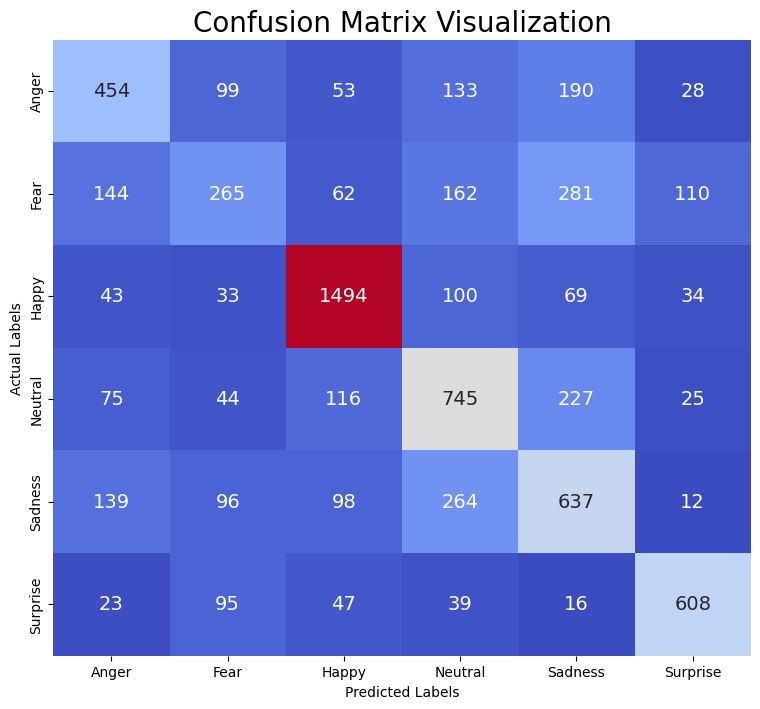

In [18]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix_data = confusion_matrix(true_labels, predicted_labels)
conf_matrix_df = pd.DataFrame(conf_matrix_data, columns=emotion_categories, index=emotion_categories)
conf_matrix_df.index.name = 'Actual Labels'
conf_matrix_df.columns.name = 'Predicted Labels'

# Plotting the confusion matrix
plt.figure(figsize=(9, 8))
plt.title('Confusion Matrix Visualization', fontsize=20)
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap='coolwarm', cbar=False, annot_kws={'size': 14})
plt.show()


In [19]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.517     0.474     0.495       957
           1      0.419     0.259     0.320      1024
           2      0.799     0.843     0.820      1773
           3      0.516     0.605     0.557      1232
           4      0.449     0.511     0.478      1246
           5      0.744     0.734     0.739       828

    accuracy                          0.595      7060
   macro avg      0.574     0.571     0.568      7060
weighted avg      0.588     0.595     0.588      7060



In [20]:
torch.save(model, 'efficientnetb0.pth')